In [1]:
import pandas as pd
# from retentioneering import datasets
from typing import Literal, Union, List, Optional, Iterable, get_args, Dict, Tuple
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

from abc import ABC, abstractmethod
import warnings

import datetime
import itertools

In [2]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

for path in sys.path:
    print(path)

D:\pythonProg\Python\Python312\python312.zip
D:\pythonProg\Python\Python312\DLLs
D:\pythonProg\Python\Python312\Lib
D:\pythonProg\Python\Python312
d:\diplom\.venv

d:\diplom\.venv\Lib\site-packages
d:\diplom\.venv\Lib\site-packages\win32
d:\diplom\.venv\Lib\site-packages\win32\lib
d:\diplom\.venv\Lib\site-packages\Pythonwin
d:\diplom\product\insight_pulse


In [3]:
from eventframing.eventframe import EventFrame
from eventframing.cols_schema import EventFrameColsSchema
from eventframing.event_type import EventType

from data_preprocessing.preprocessors_lib.add_start_end_events import AddStartEndEventsPreprocessor
from data_preprocessing.preprocessors_lib.split_sessions import SplitSessionsPreprocessor

from utils.time_units import TimeUnits
from utils.time_unit_period import TimeUnitPeriod

## Data Generation

In [4]:
def generate_user_events_data(num_users=1000, num_events=10, num_cities=10, num_os=2, num_rows=5000, seed=42):
    """
    Функция для генерации данных о событиях пользователей.
    """
    # Устанавливаем seed для генератора случайных чисел
    np.random.seed(seed)

    # Создаем список пользователей
    users = ['user' + str(i) for i in range(1, num_users+1)]

    # Создаем список событий
    events = ['event' + str(i) for i in range(1, num_events+1)]

    # Создаем список дат
    dates = [datetime.datetime.now() - datetime.timedelta(days=x) for x in range(180)]

    # Создаем список городов
    cities = ['city' + str(i) for i in range(1, num_cities+1)]

    # Создаем список операционных систем
    os = ['iOS', 'Android']

    statuses = ['status' + str(i) for i in range(1, num_os+1)]

    # Создаем DataFrame
    df = pd.DataFrame({
        'user_id': np.random.choice(users, num_rows),
        'event': np.random.choice(events, num_rows),
        'event_datetime': np.random.choice(dates, num_rows),
        'city': np.random.choice(cities, num_rows),
        'operation_system': np.random.choice(os, num_rows),
        'status': np.random.choice(statuses, num_rows)
    })

    return df

In [5]:
data = generate_user_events_data(num_rows=500, num_users=5000)
cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
ef = EventFrame(data, cols_schema)
ef.to_dataframe().head()

EventFrameColsSchema(event_id=None, event_type=None, event_index=None, event_name=event, event_timestamp=event_datetime, user_id=user_id, session_id=None, cohort_group=None, custom_cols=[])


,user_id,event,event_datetime,city,operation_system,status,event_id,event_type,event_type_index
375,user1013,event9,2025-01-08 12:35:21.580188,city9,iOS,status1,375,raw,2
417,user1016,event1,2024-12-02 12:35:21.580188,city5,iOS,status1,417,raw,2
213,user1017,event7,2025-03-01 12:35:21.579538,city10,Android,status2,213,raw,2
72,user1017,event3,2025-03-19 12:35:21.579538,city8,Android,status2,72,raw,2
57,user1022,event9,2025-01-25 12:35:21.580188,city5,iOS,status2,57,raw,2


## Implementation

In [97]:
class StepMatrix:
    _path_end_event_name = 'ENDED'
    _target_cmaps = itertools.cycle(["BrBG", "PuOr", "PRGn", "RdBu"])

    def __init__(self, ef: EventFrame):
        self.ef = ef
        self.cols_schema = ef.cols_schema

    def plot(self, data: Optional[EventFrame] = None, max_steps: int = 10, threshold: float = 0.05, weight_col: str = '',
            target_events: List[str] = None, title:str = '') -> None:
        step_matrix = self._fit(data=data, max_steps=max_steps, weight_col=weight_col)
        step_matrix, rare_events = self._threshold_events(step_matrix=step_matrix, threshold=threshold)

        self._plot(step_matrix, rare_events, max_steps=max_steps, title=title, target_events=target_events)

    def plot_difference(self, segment1, segment2, data: Optional[EventFrame] = None, max_steps: int = 10, threshold: float = 0.05, weight_col: str = '',  target_events: List[str] = None, title:str = '') -> None:
        difference_matrix = self._fit_matrix_difference(segment1, segment2, data=data, max_steps=max_steps, weight_col=weight_col)
        # Применяем пороговый метод к разнице
        difference_matrix, rare_events = self._threshold_events(difference_matrix, threshold)
        self._plot(difference_matrix, rare_events, max_steps=max_steps, title=title, target_events=target_events)

    def fit(self, data: Optional[EventFrame] = None, max_steps: int = 10, threshold: float = 0.05, weight_col: str = '') -> pd.DataFrame:
        step_matrix = self._fit(data=data, max_steps=max_steps, weight_col=weight_col)
        thresholded_step_matrix, _ = self._threshold_events(step_matrix, threshold)
        return thresholded_step_matrix
    
    def fit_difference(self, segment1, segment2, data: Optional[EventFrame] = None, max_steps: int = 10, threshold: float = 0.05, weight_col: str = '') -> pd.DataFrame:
        difference_matrix = self._fit_matrix_difference(segment1, segment2, data=data, max_steps=max_steps, weight_col=weight_col)
        # Применяем пороговый метод к разнице
        thresholded_difference_matrix, _ = self._threshold_events(difference_matrix, threshold)
        return thresholded_difference_matrix
    
    def _get_data_and_schema(self, data: Optional[Union[EventFrame, pd.DataFrame]] = None, cols_schema: Optional[EventFrameColsSchema] = None) -> Tuple[pd.DataFrame, EventFrameColsSchema]:
        if data is None:
            print('data is None')
            data = self.ef.to_dataframe().copy()
            cols_schema = self.cols_schema
        else:
            if isinstance(data, EventFrame):
                cols_schema = data.cols_schema
                data = data.to_dataframe().copy()
            else:
                cols_schema = cols_schema
                data = data.copy()
        return data, cols_schema

    def _fit_matrix_difference(self,  segment1, segment2, data: Optional[EventFrame], max_steps: int, weight_col: str) -> pd.DataFrame:
        data, cols_schema = self._get_data_and_schema(data=data)
        user_col = cols_schema.user_id

        segment1_data = data[data[user_col].isin(segment1)]
        segment2_data = data[data[user_col].isin(segment2)]

        step_matrix1 = self._fit(segment1_data, cols_schema, max_steps=max_steps, weight_col=weight_col)
        step_matrix2 = self._fit(segment2_data, cols_schema, max_steps=max_steps, weight_col=weight_col)
        
        # Объединяем шаговые матрицы
        merged_matrix = pd.merge(step_matrix1, step_matrix2, left_index=True, right_index=True, suffixes=('_1', '_2'), how='outer').fillna(0)

        difference_matrix = merged_matrix.filter(like='_1').subtract(merged_matrix.filter(like='_2').values)
        difference_matrix.columns = [col.replace('_1', '') for col in difference_matrix.columns]
        return difference_matrix
    
    def _fit(self, data: Optional[pd.DataFrame] = None, cols_schema: Optional[EventFrameColsSchema] = None,
             max_steps: int = 10, weight_col: str = ''):
        data, cols_schema = self._get_data_and_schema(data=data, cols_schema=cols_schema)

        user_col = cols_schema.user_id
        event_col = cols_schema._event_name
        session_col = cols_schema.session_id
        dt_col = cols_schema.event_timestamp

        if weight_col != '':
            if weight_col not in data.columns:
                raise ValueError(f'Column {weight_col} is not in the EventFrame.')
        else:
            weight_col = session_col if session_col  is not None else user_col

        # Add column with number of step in session or the whole path
        data = data.sort_values(by=[user_col, dt_col])
        data['step'] = data.groupby(weight_col)[dt_col].cumcount() + 1
        data = data[data['step'] <= max_steps]

        # Add path terminating event if user has less steps than max_steps
        data = data.pivot_table(index=weight_col, columns='step', values=event_col, aggfunc=lambda x: x)\
            .fillna(self._path_end_event_name).reset_index()
        
        # Unpivot table into original format but with terminating event 
        data = data.melt(id_vars=weight_col, var_name='step', value_name=event_col)
        
        # Calculate the amount of weight_col units in each step
        data = data.pivot_table(index=event_col, columns='step', values=weight_col, aggfunc='nunique')\
            .fillna(0).sort_values(by=1, ascending=False).astype(float)
        
        # Normalizing table by columns
        data = data.divide(data.sum()).mul(100).round(1)
        return data
    
    def _threshold_events(self, step_matrix: pd.DataFrame, threshold: float) -> pd.DataFrame:
        normal_events = step_matrix.loc[step_matrix.abs().max(axis=1) >= threshold * 100]
        rare_events = step_matrix.loc[step_matrix.abs().max(axis=1) < threshold * 100]

        if not rare_events.empty:
            # Создаем новый индекс с учетом количества строк в thresholded_events
            thresholded_index = f'Thresholded_{rare_events.shape[0]}'
            # Добавляем новую строку к normal_events
            normal_events.loc[thresholded_index] = rare_events.sum()

        return normal_events, rare_events
    
    def _plot(self, step_matrix: pd.DataFrame, rare_events: pd.DataFrame, max_steps: int, target_events: List[str], title: str):
        if target_events is not None:
            target_events = [event for event in target_events 
                            if event in step_matrix.index or event in rare_events.index]
            target_events_count = len(target_events)
        else:
            target_events_count = 0
        n_cols = 1 
        n_rows = 1 + target_events_count  
        fig_hight = (step_matrix.shape[0] + target_events_count) * 0.6
        fig_width = max_steps * 0.6 + 1

        # Создаем фигуру с подграфиками
        grid_specs = (
            {"wspace": 0.08, "hspace": 0.04, "height_ratios": [step_matrix.shape[0], *[1 for _ in range(target_events_count)]]}
            if target_events_count > 0
            else {}
        )
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_hight), gridspec_kw=grid_specs)
        
        # Строим основную тепловую карту для step_matrix
        main_matrix_axes = axs[0] if isinstance(axs, np.ndarray) else axs
        sns.heatmap(step_matrix, cmap='Greys', ax=main_matrix_axes, fmt='0.2f', cbar=False, annot=True)
        if not title:
            title = 'Step Matrix'
        main_matrix_axes.set_title(title)
        
        # Отображаем метки оси X сверху
        main_matrix_axes.xaxis.set_ticks_position('top')
        main_matrix_axes.xaxis.tick_top()
        main_matrix_axes.set_xlabel('')  # Убираем метку оси X

        # Для каждого целевого события извлекаем соответствующие строки и строим тепловую карту
        target_height = fig_hight / (step_matrix.shape[0] + target_events_count)
        if target_events is not None:
            for idx, event in enumerate(target_events):
                target_event_row = step_matrix.loc[[event]] if event in step_matrix.index else rare_events.loc[[event]]
                # if event in step_matrix.index:  # Проверяем, существует ли событие в шаговой матрице
                #     target_event_row = step_matrix.loc[[event]]  # Извлекаем строку целевого события
                sns.heatmap(target_event_row, ax=axs[idx + 1], fmt='0.2f', cbar=False, annot=True, cmap=next(self._target_cmaps))
                
                # Устанавливаем новый заголовок и настраиваем ось
                axs[idx + 1].set_title('')  # Убираем заголовок
                axs[idx + 1].xaxis.set_visible(False)  # Скрываем метки оси X
                axs[idx + 1].set_ylabel('')  # Убираем метку оси Y


data is None
data is None


C:\Users\razue\AppData\Local\Temp\ipykernel_6880\901199415.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_events.loc[thresholded_index] = rare_events.sum()


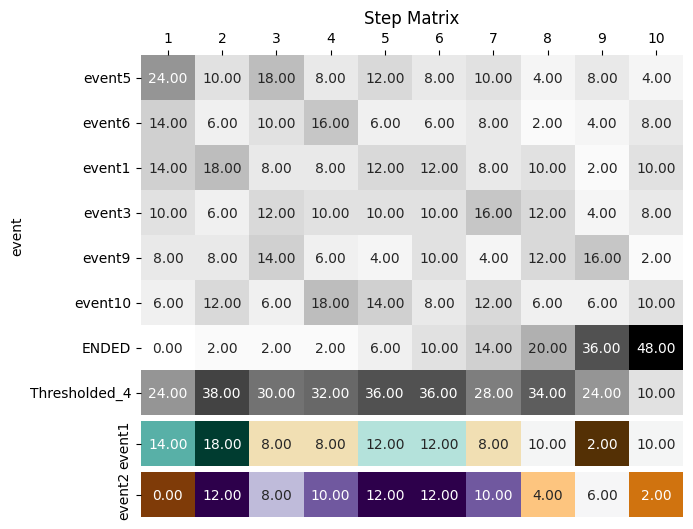

In [98]:
# data = generate_user_events_data(num_rows=500, num_users=50)
# cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
# ef = EventFrame(data, cols_schema)
# user_col = 'user_id'
# dt_col = 'event_datetime'

# data = data.sort_values(by=[user_col, dt_col])
# data.groupby('user_id')['event_datetime'].cumcount() + 1

sm = StepMatrix(ef)
m = sm.fit(max_steps=20,threshold=0.05)

# sm.plot(max_steps=20, target_events=['event1', 'event2'],threshold=0.15)
sm.plot(max_steps=10,  target_events=['event1', 'event2'], threshold=0.15, weight_col='user_id')


In [100]:
sm.fit(max_steps=100, threshold=0.15, weight_col='user_id')

data is None


C:\Users\razue\AppData\Local\Temp\ipykernel_6880\901199415.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_events.loc[thresholded_index] = rare_events.sum()


step,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
event,,,,,,,,,,,,,,,,,,
event5,24.0,10.0,18.0,8.0,12.0,8.0,10.0,4.0,8.0,4.0,2.0,8.0,2.0,2.0,0.0,0.0,0.0,0.0
event6,14.0,6.0,10.0,16.0,6.0,6.0,8.0,2.0,4.0,8.0,2.0,4.0,2.0,4.0,4.0,2.0,0.0,0.0
event1,14.0,18.0,8.0,8.0,12.0,12.0,8.0,10.0,2.0,10.0,2.0,2.0,6.0,2.0,0.0,0.0,2.0,2.0
event3,10.0,6.0,12.0,10.0,10.0,10.0,16.0,12.0,4.0,8.0,6.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0
event9,8.0,8.0,14.0,6.0,4.0,10.0,4.0,12.0,16.0,2.0,6.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0
event10,6.0,12.0,6.0,18.0,14.0,8.0,12.0,6.0,6.0,10.0,6.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0
ENDED,0.0,2.0,2.0,2.0,6.0,10.0,14.0,20.0,36.0,48.0,56.0,62.0,78.0,82.0,90.0,96.0,98.0,98.0
Thresholded_4,24.0,38.0,30.0,32.0,36.0,36.0,28.0,34.0,24.0,10.0,20.0,16.0,8.0,6.0,4.0,2.0,0.0,0.0


In [50]:
user_event_counts = data.groupby(['user_id'])['event'].nunique().reset_index()
all_events_users = user_event_counts[user_event_counts['event'] == 10]['user_id']
not_all_events_users = user_event_counts[user_event_counts['event'] < 10]['user_id'].head()

In [ ]:
sm.fit(data=data[data[user_col].isin(not_all_events_users)], max_steps=10, threshold=0.05)

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event7,20.0,20.0,0.0,20.0,20.0,20.0,0.0,20.0,0.0,0.0
event5,20.0,20.0,20.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0
event3,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
event8,20.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0
event6,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
ENDED,0.0,20.0,20.0,20.0,20.0,40.0,40.0,40.0,60.0,80.0
event1,0.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,0.0,0.0
event10,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,20.0,0.0
event2,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0


In [54]:
sm.fit(data=data[data[user_col].isin(all_events_users)], max_steps=10, threshold=0.05)

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event5,50.0,50.0,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0
event3,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event10,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,0.0
event1,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,50.0
event4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0
event6,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0
event7,0.0,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
event8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0


In [101]:
merged_matrix = sm.fit_difference(all_events_users, not_all_events_users, max_steps=10, threshold=0.05)
merged_matrix

data is None


,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
ENDED,0.0,-20.0,-20.0,-20.0,-20.0,-40.0,-40.0,-40.0,-60.0,-80.0
event1,0.0,0.0,0.0,50.0,-20.0,0.0,-20.0,-20.0,0.0,0.0
event10,0.0,-20.0,0.0,-20.0,0.0,50.0,-20.0,50.0,-20.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,-20.0,0.0,0.0,50.0
event3,30.0,0.0,-20.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event4,0.0,-20.0,-40.0,0.0,-20.0,0.0,0.0,50.0,0.0,50.0
event5,30.0,30.0,30.0,-20.0,0.0,-20.0,50.0,-20.0,0.0,0.0
event6,-20.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,-20.0
event7,-20.0,30.0,0.0,-20.0,-20.0,30.0,0.0,-20.0,0.0,0.0


data is None


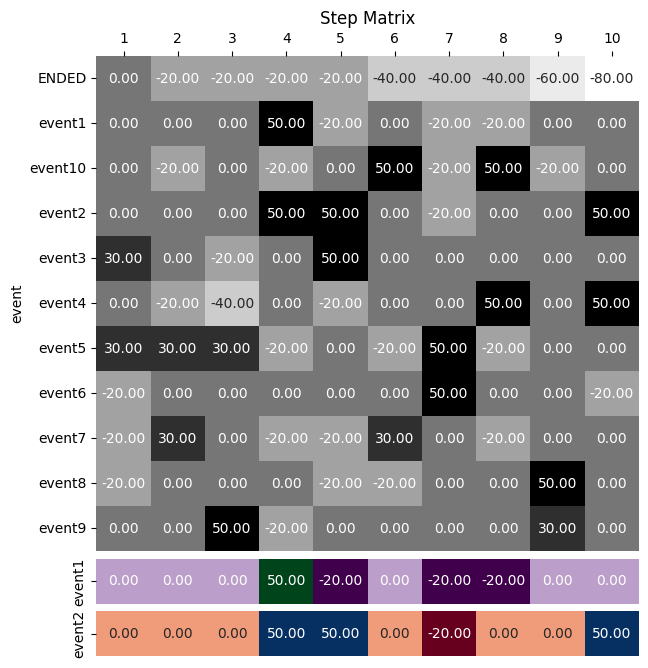

In [102]:
sm.plot_difference(all_events_users, not_all_events_users, max_steps=10, threshold=0.05, target_events=['event1', 'event2'], weight_col='user_id')

In [59]:
difference_matrix = merged_matrix.filter(like='_1').subtract(merged_matrix.filter(like='_2').values)
difference_matrix.columns = [col.replace('_1', '') for col in difference_matrix.columns]
difference_matrix

,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
ENDED,0.0,-20.0,-20.0,-20.0,-20.0,-40.0,-40.0,-40.0,-60.0,-80.0
event1,0.0,0.0,0.0,50.0,-20.0,0.0,-20.0,-20.0,0.0,0.0
event10,0.0,-20.0,0.0,-20.0,0.0,50.0,-20.0,50.0,-20.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,-20.0,0.0,0.0,50.0
event3,30.0,0.0,-20.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event4,0.0,-20.0,-40.0,0.0,-20.0,0.0,0.0,50.0,0.0,50.0
event5,30.0,30.0,30.0,-20.0,0.0,-20.0,50.0,-20.0,0.0,0.0
event6,-20.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,-20.0
event7,-20.0,30.0,0.0,-20.0,-20.0,30.0,0.0,-20.0,0.0,0.0


In [52]:
not_all_events_users

0     user1
1    user10
2    user11
3    user12
4    user13
Name: user_id, dtype: object

In [130]:

# step_cols = [i for i in range(1, max_steps + 1)]
# m.loc[:, step_cols] = m.loc[:, step_cols].divide(m.loc[:, step_cols].sum()).mul(100).round(1)
threshold: float = 0.15
normal_events = m.loc[m.max(axis=1) >= threshold * 100]
thresholded_events = m.loc[m.max(axis=1) < threshold * 100]

# Суммируем значения всех строк в thresholded_events
sum_row = thresholded_events.sum()

# Создаем новый индекс с учетом количества строк в thresholded_events
new_index = f'Thresholded_{thresholded_events.shape[0]}'

# Добавляем новую строку к normal_events
normal_events.loc[new_index] = sum_row

C:\Users\razue\AppData\Local\Temp\ipykernel_10108\3317989321.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_events.loc[new_index] = sum_row


In [131]:
normal_events

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event9,6.0,6.0,10.0,4.0,24.0,8.0,6.0,6.0,10.0,6.0
Thresholded_3,30.0,24.0,24.0,20.0,30.0,30.0,24.0,32.0,24.0,24.0


In [121]:
m

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event4,14.0,8.0,14.0,8.0,10.0,10.0,10.0,14.0,8.0,4.0
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event8,10.0,10.0,6.0,10.0,10.0,8.0,6.0,6.0,10.0,12.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event7,6.0,6.0,4.0,2.0,10.0,12.0,8.0,12.0,6.0,8.0


In [107]:
m

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event4,14.0,8.0,14.0,8.0,10.0,10.0,10.0,14.0,8.0,4.0
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event8,10.0,10.0,6.0,10.0,10.0,8.0,6.0,6.0,10.0,12.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event7,6.0,6.0,4.0,2.0,10.0,12.0,8.0,12.0,6.0,8.0


In [92]:
m.set_index('event')

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event6,11.6,9.4,13.0,6.4,11.0,10.6,9.4,9.0,6.2,5.4
event3,11.0,10.2,9.0,10.8,9.2,6.2,7.8,6.0,5.8,4.8
event9,10.8,8.6,11.2,8.8,9.2,9.4,8.8,6.6,5.0,5.2
event5,10.6,9.2,9.0,11.0,10.8,7.0,8.0,6.6,7.4,5.2
event4,10.2,10.4,9.4,10.0,7.2,8.0,9.8,6.6,6.4,3.8
event2,10.0,9.0,8.2,10.2,10.6,9.2,7.0,8.4,8.0,6.6
event10,9.8,10.8,9.8,11.8,10.6,10.6,8.6,7.8,6.4,6.4
event1,8.8,10.6,11.2,9.0,8.8,8.2,7.0,8.0,6.0,7.4
event7,8.6,12.0,10.2,10.0,11.2,12.4,7.4,9.0,8.8,6.6


In [50]:
data['step'] = data.groupby('user_id')['event_datetime'].cumcount() + 1
data[data['user_id'] == 'user99']

,user_id,event,event_datetime,city,operation_system,status,step
163,user99,event3,2025-03-02 21:37:10.545635,city8,iOS,status1,1
351,user99,event9,2025-01-06 21:37:10.545635,city7,Android,status2,2
370,user99,event5,2024-11-08 21:37:10.545635,city10,Android,status2,3
393,user99,event10,2025-01-13 21:37:10.545635,city3,Android,status2,4
462,user99,event8,2024-12-27 21:37:10.545635,city3,Android,status1,5
472,user99,event9,2025-01-13 21:37:10.545635,city6,Android,status2,6
